In [2]:
## DACON에서 대회 준비중인 수정전 파일입니다.
import tensorflow as tf
import os
import numpy as np
import PIL

from PIL import Image
from glob import glob

In [3]:
root = './dacon1/train/'
training_images = []
training_labels = []

for filename in glob(root +"*"):
    for img in glob(filename + "/*.jpg"):
        an_img = PIL.Image.open(img)
        img_array = np.array(an_img)
        training_images.append(img_array)
        label = filename.split('\\')[-1]
        training_labels.append(label)
        
training_images = np.array(training_images)
training_labels = np.array(training_labels)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

print(training_images.shape)
print(training_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


In [4]:
root2 = './dacon1/test/'
test_images = []
test_idx = []

flist = sorted(glob(root2 + '*.jpg'))

for filename in flist:
    an_img = PIL.Image.open(filename)
    img_array = np.array(an_img)
    test_images.append(img_array)
    label = filename.split('\\')[-1]
    test_idx.append(label)
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:3])

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg']


[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],

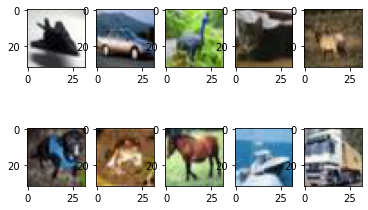

In [5]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(training_images[i*5000])
    print(training_labels[i*5000], end=",")
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

image_generator = ImageDataGenerator(
    rotation_range=45,
    brightness_range = [0.6, 1.0],
    zoom_range=0.4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    vertical_flip = False
)

In [7]:
augment_size=150000

np.random.seed(42)

mask = np.random.randint(training_images.shape[0], size=augment_size)
training_image2 = training_images[mask].copy()
training_labels2 = training_labels[mask].copy()

In [8]:
training_image2 = image_generator.flow(training_image2, np.zeros(augment_size), batch_size=augment_size, shuffle=False, seed = 42).next()[0]

training_images = np.concatenate((training_images, training_image2))
training_labels = np.concatenate((training_labels, training_labels2))

In [9]:
print(training_images.shape)
print(training_labels.shape)

(200000, 32, 32, 3)
(200000, 1)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(training_images, training_labels, test_size=0.06, random_state=42)

X_test = test_images

In [11]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(188000, 32, 32, 3)
(12000, 32, 32, 3)
(10000, 32, 32, 3)


In [12]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.GlobalAveragePooling2D(), #pooling layer

    tf.keras.layers.Dense(256, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

In [14]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
#steps_per_epoch과 validation_steps크기를 알아보기 위한 수식

steps_per_epoch = len(X_train)// 128
validation_steps = len(X_test)// 128 # --> 128은 배치 사이즈 갯수이다.

print(steps_per_epoch, validation_steps)

1468 78


In [ ]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), steps_per_epoch = 1468, validation_steps = 78,
           epochs = 40, batch_size = 128, verbose = 2)

Epoch 1/40


In [29]:
pred_proba = model.predict(X_test) 

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)
    
pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array(['horse', 'bird', 'airplane', 'dog', 'airplane'], dtype='<U10')

In [31]:
import pandas as pd

sample_submission = pd.read_csv("./dacon1/sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("submit.csv",index=False)

In [32]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,bird
2,0002.jpg,airplane
3,0003.jpg,dog
4,0004.jpg,airplane
